# Computación Científica II
## Laboratorio  #4
    
   Gabriela González Toledo      gabriela.gonzalez@alumnos.usm.cl  201173017-8
   
   Ian Zamorano Escobedo         Ian.zamorano.12@sansano.usm.cl    201273018-k

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

import timeit
from math import ceil, floor
from sympy import *
from sympy.abc import *
from scipy.special import gamma
from matplotlib import cm

#%load_ext line_profiler

### Introducción:

El presente laboratorio tiene como objetivo comprender y aplicar los métodos de Integración Numérica. Para esto implementaremos  los cuatro métodos vistos en clases. En la primera parte trabajaremos aplicando los métodos a una integral impropia, haciendo un cambio de variable y calculando los tiempos de ejecución de cada método. La segunda parte consta de implementar un método para calcular derivadas fraccionarias y hacer cálculos de algunas derivadas para luego analizar su comportamiento al variar la fracción entre sus enteros superior e inferior.

### Ley de Ampere

#### 1. Ecuación característica:

$$
\vec{\nabla} \times \vec{B} =\mu_0 \vec{J} + \mu_0 \epsilon_0 \cfrac{\partial \vec{E}}{\partial t} 
$$

$$
\vec{J} = \vec{0}
$$

$$
\vec{\nabla} \times \vec{B} = \mu_0 \epsilon_0 \cfrac{\partial \vec{E}}{\partial t} \qquad / \; \vec{\nabla} \times
$$

$$
\vec{\nabla} \times (\vec{\nabla} \times \vec{B}) = \vec{\nabla} \times \mu_0 \epsilon_0 \cfrac{\partial \vec{E}}{\partial t}
$$

$$
\vec{\nabla} (\vec{\nabla} \vec{B}) - \vec{\nabla}^{2} \vec{B} = \vec{\nabla} \times \mu_0 \epsilon_0 \cfrac{\partial \vec{E}}{\partial t}
$$

$$
Por ~ Gauss (\vec{\nabla} \cdot \vec{B} = 0)
$$

$$
\therefore - \vec{\nabla}^{2} \vec{B} = \vec{\nabla} \times \mu_0 \epsilon_0 \cfrac{\partial \vec{E}}{\partial t}
$$

$$
Por ~ Faraday-Lenz \left( \vec{\nabla} \times \vec{E} = - \cfrac{\partial B }{\partial t}\right)
$$

$$
 - \vec{\nabla}^{2} \vec{B} = - \mu_0 \epsilon_0 \cfrac{\partial^2 \vec{B}}{\partial t^2}
$$

$$
 \vec{\nabla}^{2} \vec{B} = \mu_0 \epsilon_0 \cfrac{\partial^2 \vec{B}}{\partial t^2}
$$

$$
\vec{B}_{xx} + \vec{B}_{yy}= \mu_0 \epsilon_0 \vec{B}_{tt}
$$


#### 2. Significado fisico:

$\epsilon_0$ : Fisicamente esta constante representa la permitividad eléctrica del vacío.

$\mu_0 $ : Esta constante corresponde a la permeabilidad magnética del vacío.

#### 3.  Discretizacion de ecuacion de onda

$$
\vec{B} \rightarrow u
$$

$$
u_{i,j,k} = B(x_i,y_j,t_k) = u(i\Delta x, j\Delta y, k \Delta t) \qquad i,j,k \in \{1,2,3, \dots , N\}
$$

$$
u_{xx} = \cfrac{u_{i-1,j,k} + 2 u_{i,j,k} + u_{i+1,j,k}}{\Delta x^{2}}
$$

$$
u_{yy} = \cfrac{u_{i,j-1,k} + 2 u_{i,j,k} + u_{i,j+1,k}}{\Delta y^{2}}
$$

$$
u_{tt} = \cfrac{u_{i,j,k-1} + 2 u_{i,j,k} + u_{i+1,j,k+1}}{\Delta t^{2}}
$$


#### 4. Analisis de sensibilidad

#### 5. Resolucion del problema.

### Analisis práctico

#### 1. implementacion pde_solver

In [2]:
def pde_solver(h, k, t_max, c, f, g, period=True, alpha=1, beta=1, l=0 , r=0):
    Nx = int(2/h) + 1 
    Nt = int(t_max/k) + 1
    x = np.linspace(-1,1,Nx)
    t = np.linspace(0,t_max, Nt)
    u = np.zeros((Nx,Nt))
    i = np.arange(1,Nx-1)
    i = map(int, i)
    i = np.array(i)
    dx = h
    dt = k
    sigma_2 = (c(x[i])*dt/dx)**2
    print "delta cuadrado" , sigma_2
    for j, j_t in enumerate(t):
        if j == 0:
            u[:,0]= f(x)
        elif j==1:
            u[ i, j] = 0.5*sigma_2*u[i+1,j-1] + (1 - sigma_2)*u[i,j-1] + 0.5*sigma_2*u[i-1, j-1] + dt*g(x[i])
            if period:
                u[ 0, j] = 0.5*sigma_2*u[1,j-1] + (1 - sigma_2)*u[0,j-1] + 0.5*sigma_2*u[-2, j-1] + dt*g(x[0])
                u[-1, j] = u[0 , j]
            else:
                u[-1, j] = (dx*r(j_t)+ (1 -beta)*u[-2,j])/(beta*(dx-1)+1)
                u[ 0, j] = (dx*l(j_t)-(1-alpha)*u[1,j])/(alpha*(dx+1)-1)
        else:
            u[i,j] = sigma_2*u[i+1,j-1]+(2-2*sigma_2)*u[i,j-1]+sigma_2*u[i-1,j-1]-u[i,j-2]
            if period:
                u[ 0, j] = 0.5*sigma_2*u[1,j-1] + (1 - sigma_2)*u[0,j-1] + 0.5*sigma_2*u[-2, j-1] + dt*g(x[0])
                u[-1, j] = u[0 , j]
            else:
                u[-1, j] = (dx*r(j_t)+ (1 -beta)*u[-2,j])/(beta*(dx-1)+1)
                u[ 0, j] = (dx*l(j_t)-(1-alpha)*u[1,j])/(alpha*(dx+1)-1)
    return x , t , np.transpose(u)

#### 2.Cálculo longitud de onda y tiempo

In [3]:
#datos
f = lambda x: 100*np.sin(x**2)
g = lambda x: 200*x*np.sin(x**2)
c = lambda x: 1
l = lambda t: 0
r = lambda t: 0

In [4]:
#funcion para graficar la superficie
def graficar_superficie(x,t,u,titulo):
    fig = plt.figure()
    ax = fig.gca(projection='3d',title = titulo, xlabel = "x", ylabel = "t", zlabel="u")
    X, T = np.meshgrid(x, t)
    surf = ax.plot_surface(X, T, u, rstride=1,cmap=cm.coolwarm,cstride=1,linewidth=0, antialiased=False)
    print X.shape
    bul = (u.shape == X.shape and T.shape == u.shape)
    plt.show()

In [5]:

# Dirichlet
n = ([2.0/100,2.0/300,2.0/500,2.0/700,2.0/1000])
for m in range(len(n)):
    h = n[m]
    x, t, u = pde_solver(h, 0.01, 8, c, f, g, False , 1, 1, l, r)
    print "solve listo"
    print "---------"
    titulo = "Dirichlet con h =" + str(h) + " y k = 0.01"
    graficar_superficie(x,t,u,titulo)


#Robin


delta cuadrado 0.25
solve listo
---------
(801L, 101L)
delta cuadrado

C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in multiply
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in add
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in subtract
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in add
C:\Users\ianza\Anaconda2\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1640: RuntimeWarning: invalid value encountered in double_scalars
  avgzsum = sum(p[2] for p in ps2)
C:\Users\ianza\Anaconda2\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:1640: RuntimeWarning:

 2.25
solve listo
---------


C:\Users\ianza\Anaconda2\lib\site-packages\matplotlib\ticker.py:1299: RuntimeWarning: overflow encountered in double_scalars
  dv = abs(vmax - vmin)
C:\Users\ianza\Anaconda2\lib\site-packages\matplotlib\ticker.py:1407: RuntimeWarning: overflow encountered in double_scalars
  raw_step = (vmax - vmin) / nbins
C:\Users\ianza\Anaconda2\lib\site-packages\matplotlib\ticker.py:1416: RuntimeWarning: invalid value encountered in double_scalars
  best_vmin = step * divmod(vmin, step)[0]
C:\Users\ianza\Anaconda2\lib\site-packages\matplotlib\ticker.py:1421: RuntimeWarning: invalid value encountered in double_scalars
  extra_bins = int(divmod((best_vmax - vmax), step)[0])


ValueError: cannot convert float NaN to integer

delta cuadrado 0.25
(401L, 101L)


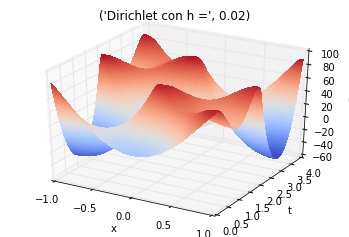

delta cuadrado 2.25


C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in multiply
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in add
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in add
C:\Users\ianza\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in subtract


ValueError: cannot convert float NaN to integer

C:\Users\ianza\Anaconda2\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
C:\Users\ianza\Anaconda2\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:161: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


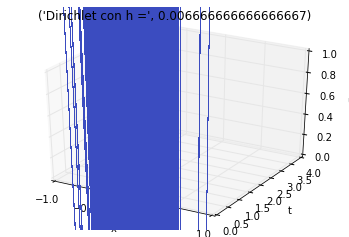

In [6]:
%matplotlib inline
# Neumann
n = ([2.0/100,2.0/300,2.0/500,2.0/700,2.0/1000])
for m in range(len(n)):
    h = n[m]
    x, t, u = pde_solver(h, 0.01, 4, c, f, g, False , 0, 0, l, r)
    titulo = "Dirichlet con h =", h
    graficar_superficie(x,t,u,titulo)

delta cuadrado 0.0025
(4001L, 101L)


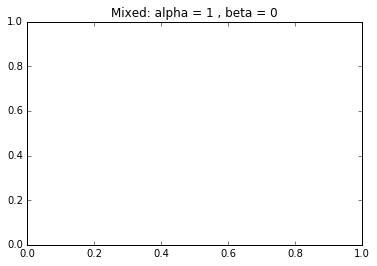

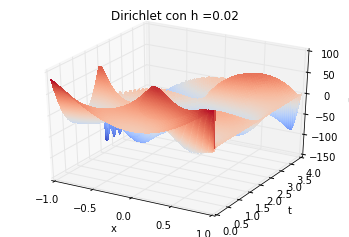

delta cuadrado 0.0225
(4001L, 301L)


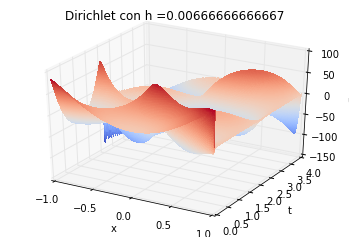

delta cuadrado 0.0625


KeyboardInterrupt: 

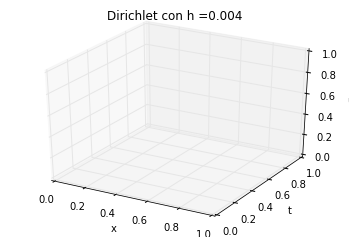

In [10]:

# Mixed, alpha = 1 , beta = 0
plt.title("Mixed: alpha = 1 , beta = 0")
n = ([2.0/100,2.0/300,2.0/500,2.0/700,2.0/1000])
for m in range(len(n)):
    h = n[m]
    x, t, u = pde_solver(h, 0.001, 4, c, f, g, False , 0, 1, l, r)
    titulo = "Dirichlet con h =" + str(h)
    graficar_superficie(x,t,u,titulo)



# Mixed, alpha = 0 , beta = 1
n = ([2.0/100,2.0/300,2.0/500,2.0/700,2.0/1000])
for m in range(len(n)):
    h = n[m]
    x, t, u = pde_solver(h, 0.001, 4, c, f, g, False , 1, 0, l, r)
    titulo = "Dirichlet con h =" + str(h)
    graficar_superficie(x,t,u,titulo)

In [ ]:
%matplotlib inline
# Periodica
n = ([2.0/100,2.0/300,2.0/500,2.0/700,2.0/1000])
for m in range(len(n)):
    h = n[m]
    x, t, u = pde_solver(h, 0.001, 1, c, f, g)
    titulo = "Dirichlet con h =" + str(h)
    graficar_superficie(x,t,u,titulo)


#### 3. Cálculo de integrales

### Conclusión:

### Referencias

http://matplotlib.org/examples/mplot3d/surface3d_demo.html
